<a href="https://colab.research.google.com/github/btcain44/Applied_Deep_Learning/blob/main/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bi-Weekly Report #6
### Brian Cain
#### Super_Resolution.ipynb

In this notebook, I am going to be attemtping some stratgies covered in the <b>Super-Resolution, Denoising, and Colorization</b> module covered in class. Specifically, I will be focusing on the <b>Super-Resolution</b> techniques covered in this module. 

As an experiment with Super-Resolution, I will be training a model that aims at increasing the resolution in low-resolution images based off samples from Caltech-101. I have yet to work with the Caltech-101 dataset but the images have fairly high resolution making them a good candidate for this training task. It also seems that the Caltech-101 dataset have a ton of different labels in it which bodes well to generalizing super-resolution on different datasets. I will then apply the model to CIFAR-100 images to try to increase the resolution of those samples. I am doing this, because in my prior work with CIFAR-100, it is easily noticeable that the images are extremely low resolution so it might be helpful for future prediction tasks to increase image resolution on CIFAR-100. 

Below I pull in the Caltech data using the PyTorch datasets module:

In [ ]:
##Import necessary packages
import tensorflow as tf
import torchvision.transforms as transforms
import numpy as np

##Define a transformer to get image data into tensors
transform = transforms.Compose(
   [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
   ])
# Construct a tf.data.Dataset
from torchvision import transforms, datasets
caltech = datasets.Caltech101('',transform=transform,download=True)

##Iterate through the caltech dataset to transform to numpy arrays
caltech_np = []
for i in range(len(caltech)):
  try:
    img = caltech[i][0].numpy()
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    caltech_np.append(img)
  except:
    continue

0it [00:00, ?it/s]

Extracting caltech101/101_ObjectCategories.tar.gz to caltech101


0it [00:00, ?it/s]

Extracting caltech101/101_Annotations.tar to caltech101


In [ ]:
##Clear caltech non-array out of memory to free up RAM
del caltech

I upgraded to Collab Pro and am continuing to get kicked off for going over the RAM with Caltech, so I will randomly trim the dataset here band keep 2000 datapoints so I have enough RAM to train a model:

In [ ]:
##Get random sample from list
import random
caltech_np = random.sample(caltech_np, 2000)

Now lets visualize some random observations from the acquired sample of Caltech-101:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 2000 + 1) instead
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imsh

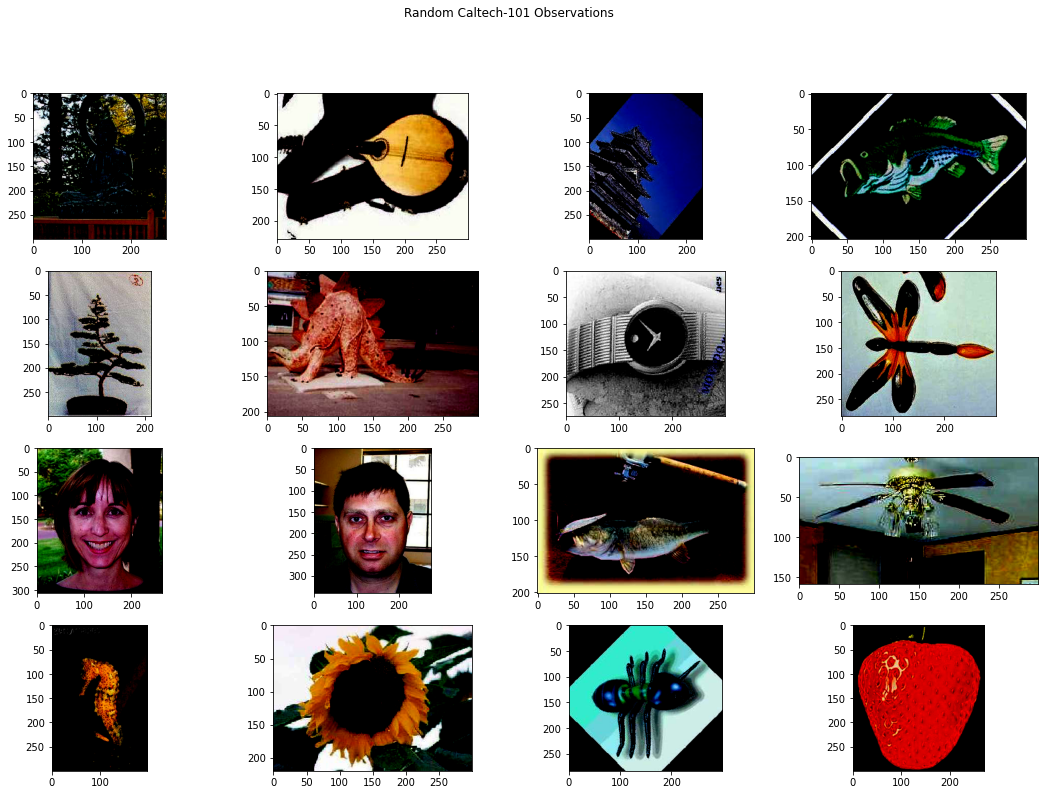

In [ ]:
##Import necessary plotting package
import matplotlib.pyplot as plt

##Use function to plot random image from previous notebooks
##Define a function that will display random samples for each class for us
def display_rand_samples(rows,columns,imgData,title):
  
  ##Generate random samples
  randomSamples = np.random.random_integers(len(imgData),size=rows*columns)

  ##Create figure to output images onto
  fig, ax = plt.subplots(rows,columns,figsize=(15,10))

  ##Loop through labels to display random samples for each label onto subplot
  ct = 0
  for i in range(rows):
    for j in range(columns):
      ax[i,j].imshow(imgData[randomSamples[ct]],cmap='gray')
      ct+=1

  ##Format overall plot structure
  fig.suptitle(title,y=1.1)
  fig.tight_layout()

##Call the function to plot random observations from each super-class (coarse labels)
np.random.seed(10) ##Set random seed so visualization results can be replicated
display_rand_samples(4,4,caltech_np,'Random Caltech-101 Observations')

Looking at these random samples from the Caltech-101 dataset, I am encouraged that this dataset is a good selection for this Super-Resolution task. Here are a few reasons why:

* There are many categories of images like machinery (eg. airplane, motorbike, not seen here but we know Caltech-101 contains them), animals (ig. fish, spider), humans, widgets (eg. watch) which bodes well for the Super-Resolution model to extend well to many types of photos that we might see in CIFAR-100
* The images appear to be fairly high resolution so it will serve well as good data for our model to train on in order to make low resolution pictures higher resolution

Things that need to be done before training a Super-Resolution model on this data:

* All Images must be put into the same height/width dimensions
* Training data must be generated which will make these images have a lower resolution

For the second bullet here, we can recognize that the data above will end up being the high-resolution ground truth data. We will lower the resolution of these images for the model to train on. 

<b>Make Caltech-101 Dimensions all the Same</b>

Lets simply obtain what the average height/width dimension in the Caltech-101 dataset is and then adjust all photos to be of these dimensions. 

In [ ]:
##Obtain the average dimensions of the Caltech-101 images
height = []
width = []
channel = []
for i in caltech_np:
  imgShape = i.shape
  height.append(imgShape[0])
  width.append(imgShape[1])
  channel.append(imgShape[2])

##Display the averages
print('Average Dimensions of Caltech 101 Images')
print('----------------------------------------')
print('Average Height: '+str(np.mean(height)))
print('Average Width: '+str(np.mean(width)))
print('Average Channel: '+str(np.mean(channel)))

Average Dimensions of Caltech 101 Images
----------------------------------------
Average Height: 239.9395
Average Width: 298.3125
Average Channel: 3.0


In [ ]:
##Free up RAM
del height
del width
del channel

Given these results, we can see that the average channel amount is perfectly 3, indicating as suspected, all images are already in RGB. For the height and width, I will round up the dimension to the nearest 10, so by these results, the new uniform image height will be 240, and width will be 300. 

Change the resolutions:

In [ ]:
##Import necessary package for changing image resolution
import cv2

##Change resolution of images
for i in range(len(caltech_np)):
  resized = cv2.resize(caltech_np[i], (240,300), interpolation = cv2.INTER_AREA)
  caltech_np[i] = resized

##Change to numpy array
caltech_np = np.array(caltech_np)

Now lets display the same image samples above with the re-defined resolution:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 2000 + 1) instead
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imsh

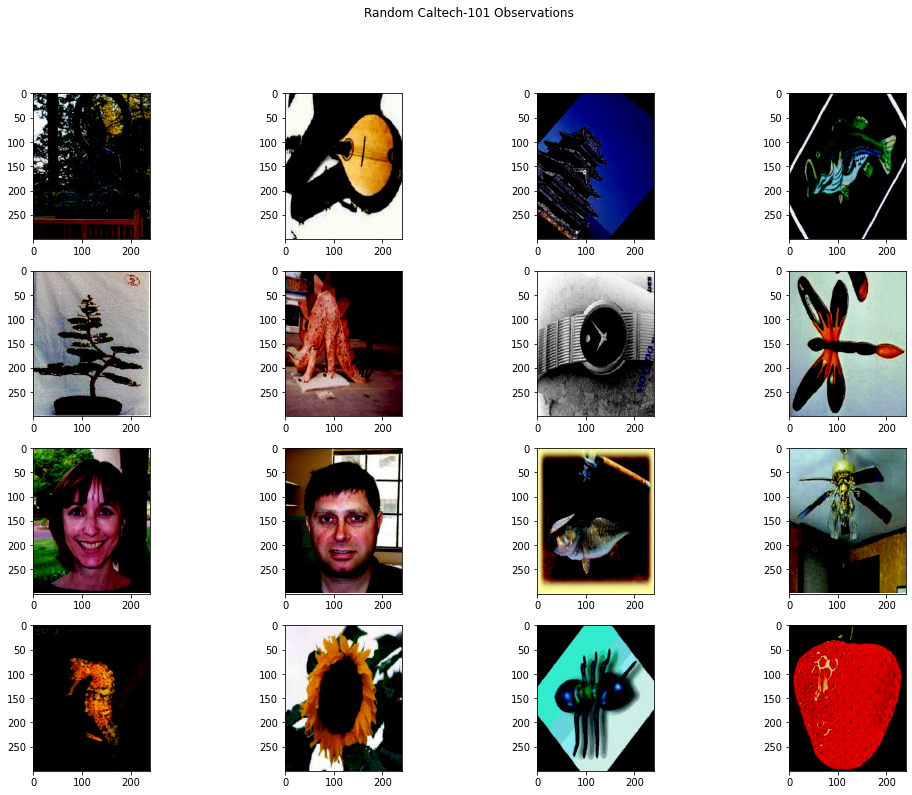

In [ ]:
##Call the function to plot random observations from each super-class (coarse labels)
np.random.seed(10) ##Set random seed so visualization results can be replicated
display_rand_samples(4,4,caltech_np,'Random Caltech-101 Observations')

Now above we can see that the images have been resized to all have the same dimensions. We can also note that the images still have pretty high resolution, which is great so that it still serves as good data to train our super-resolution model on. 

<b>Generate Caltech-101 Lower-Resolution Images</b>

Now it is necessary to generate lower resolution images for the Caltech-101 samples so that our model can train and evaluate its performance against the ground truth higher resolution photos. In order to do this I will use Gaussian blurring on each Caltech-101 image and then assess if it has the desired visual results at giving low resolution samples. 

Perform Guassian blurring:

In [ ]:
##Generate gaussian blur images
caltech_blur = []
for i in range(len(caltech_np)):
	caltech_blur.append(cv2.GaussianBlur(caltech_np[i],(9,9),cv2.BORDER_DEFAULT))
 
##Format as numpy array
caltech_blur = np.array(caltech_blur)

Now let's visualize how the original images compare to the guassian blurred version of themselves. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 2000 + 1) instead
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imsh

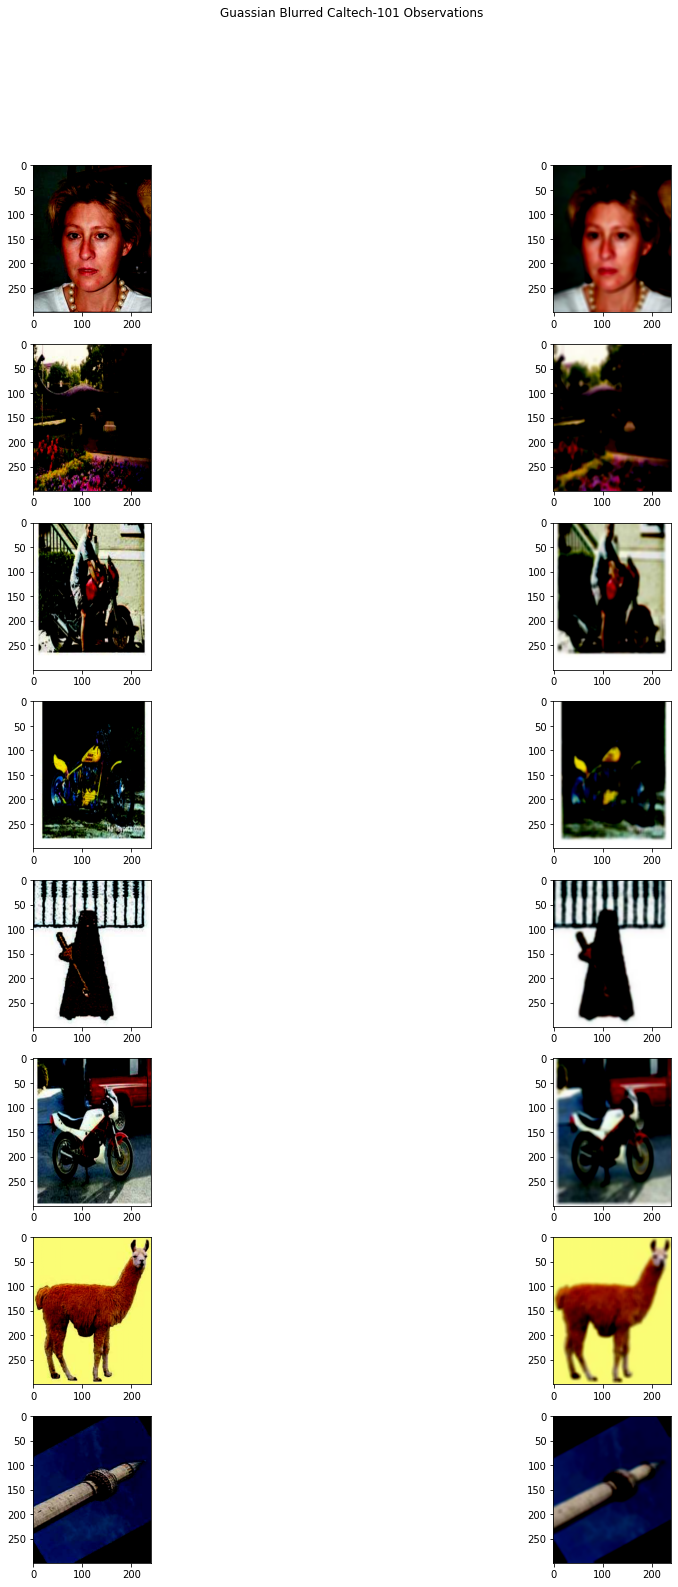

In [ ]:
##Import necessary plotting package
import matplotlib.pyplot as plt

##Use function to plot random image from previous notebooks
##Define a function that will display random samples for each class for us
def display_rand_samples(num_samps,imgData,blurData,title):
  
  ##Generate random samples
  randomSamples = np.random.random_integers(len(imgData),size=num_samps)

  ##Create figure to output images onto
  fig, ax = plt.subplots(num_samps,2,figsize=(20,20))

  ##Loop through labels to display random samples for each label onto subplot
  ct = 0
  for i in randomSamples:
      ax[ct,0].imshow(imgData[randomSamples[ct]],cmap='gray')
      ax[ct,1].imshow(blurData[randomSamples[ct]],cmap='gray')
      ct+=1

  ##Format overall plot structure
  fig.suptitle(title,y=1.1)
  fig.tight_layout()

##Call the function to plot random observations from each super-class (coarse labels)
np.random.seed(11) ##Set random seed so visualization results can be replicated
display_rand_samples(8,caltech_np,caltech_blur,'Guassian Blurred Caltech-101 Observations')

Looking at these results the Guassian blurring appears to be doing exactly what is desired. Overall, we can note that the overall structure of each image is remaining the same and macro-object information can still be seen. 

Here are a few more observations:
* There are some images that have very dark lighting, which when blurred it is very difficult to make out the image, this could hinder some model predictions
* Overall information on a macro scale is preserved with the blurring
* Small details, like the eyes of the person in row 1 have lost a lot of visual information

### Create Super-Resolution Model

Now that we have our data for the model to evaluate itself on, we can train a Super-Resolution Model. I used the following resource to serve as an aid: https://towardsdatascience.com/image-super-resolution-using-convolution-neural-networks-and-auto-encoders-28c9eceadf90 although the super-resolution problem I am working on is quite different than in this article. 

Construct the Model:

In [ ]:
##Import the necessary packages
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

##Define the input size of the Caltech resized dimensions
Input_img = Input(shape=(300, 240, 3))  
    
##Define the encoder architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)

##Define the decoder architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

##Put all the model pieces back together
autoencoder = Model(Input_img, decoded)

##Compile the model
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
##Lets display a summary of the model
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 300, 240, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 300, 240, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

Something included in the article example was early stopping, so I decided to use it for my use-case. I have yet to use early stopping but figured it would be good to get familiar with as it seems at times better than just letting the model run for a pre-determined number of epochs. 

I decided to stop the training process if 5 epochs have passed and there was not a change in validation loss of more than .01. 

In [ ]:
##Declare early stopping when we are no longer seeing significant changes in the performance of the model
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1, mode='min')

Now the data must be split into a training and validation set:

In [ ]:
##Normalize the images
#caltech_np, caltech_blur = caltech_np / 255, caltech_blur / 255 

##Split training data so we have a validation set
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(caltech_blur, caltech_np, test_size=0.15, random_state=42)

##Free up more RAM
del caltech_blur
del caltech_np

Now we can go ahead and train the model:

In [ ]:
##Fot the super-resolution model
autoencoder.fit(x_train,y_train,epochs=20,
                                  batch_size=1,validation_data=(x_val, y_val),
                                  callbacks=[early_stopper])

Epoch 1/20
1700/1700 [==============================] - 53s 21ms/step - loss: 0.1960 - accuracy: 0.6473 - val_loss: 0.1837 - val_accuracy: 0.6846
Epoch 2/20
1700/1700 [==============================] - 36s 21ms/step - loss: 0.1822 - accuracy: 0.6680 - val_loss: 0.1811 - val_accuracy: 0.6008
Epoch 3/20
1700/1700 [==============================] - 36s 21ms/step - loss: 0.1811 - accuracy: 0.6658 - val_loss: 0.1820 - val_accuracy: 0.6295
Epoch 4/20
1700/1700 [==============================] - 36s 21ms/step - loss: 0.1810 - accuracy: 0.6651 - val_loss: 0.1785 - val_accuracy: 0.7278
Epoch 5/20
1700/1700 [==============================] - 36s 21ms/step - loss: 0.1800 - accuracy: 0.6744 - val_loss: 0.1789 - val_accuracy: 0.7131
Epoch 6/20
1700/1700 [==============================] - 36s 21ms/step - loss: 0.1801 - accuracy: 0.6667 - val_loss: 0.1790 - val_accuracy: 0.6402
Epoch 00006: early stopping


We can note that we never really were able to lower the validation loss in the early stages of the training causing the early stopping to end the training process. Below I have plotted some super-resolution predictions to see how our model performs even though training ended so early.

Plot some of the results on our validation set:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 300 + 1) instead
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imsho

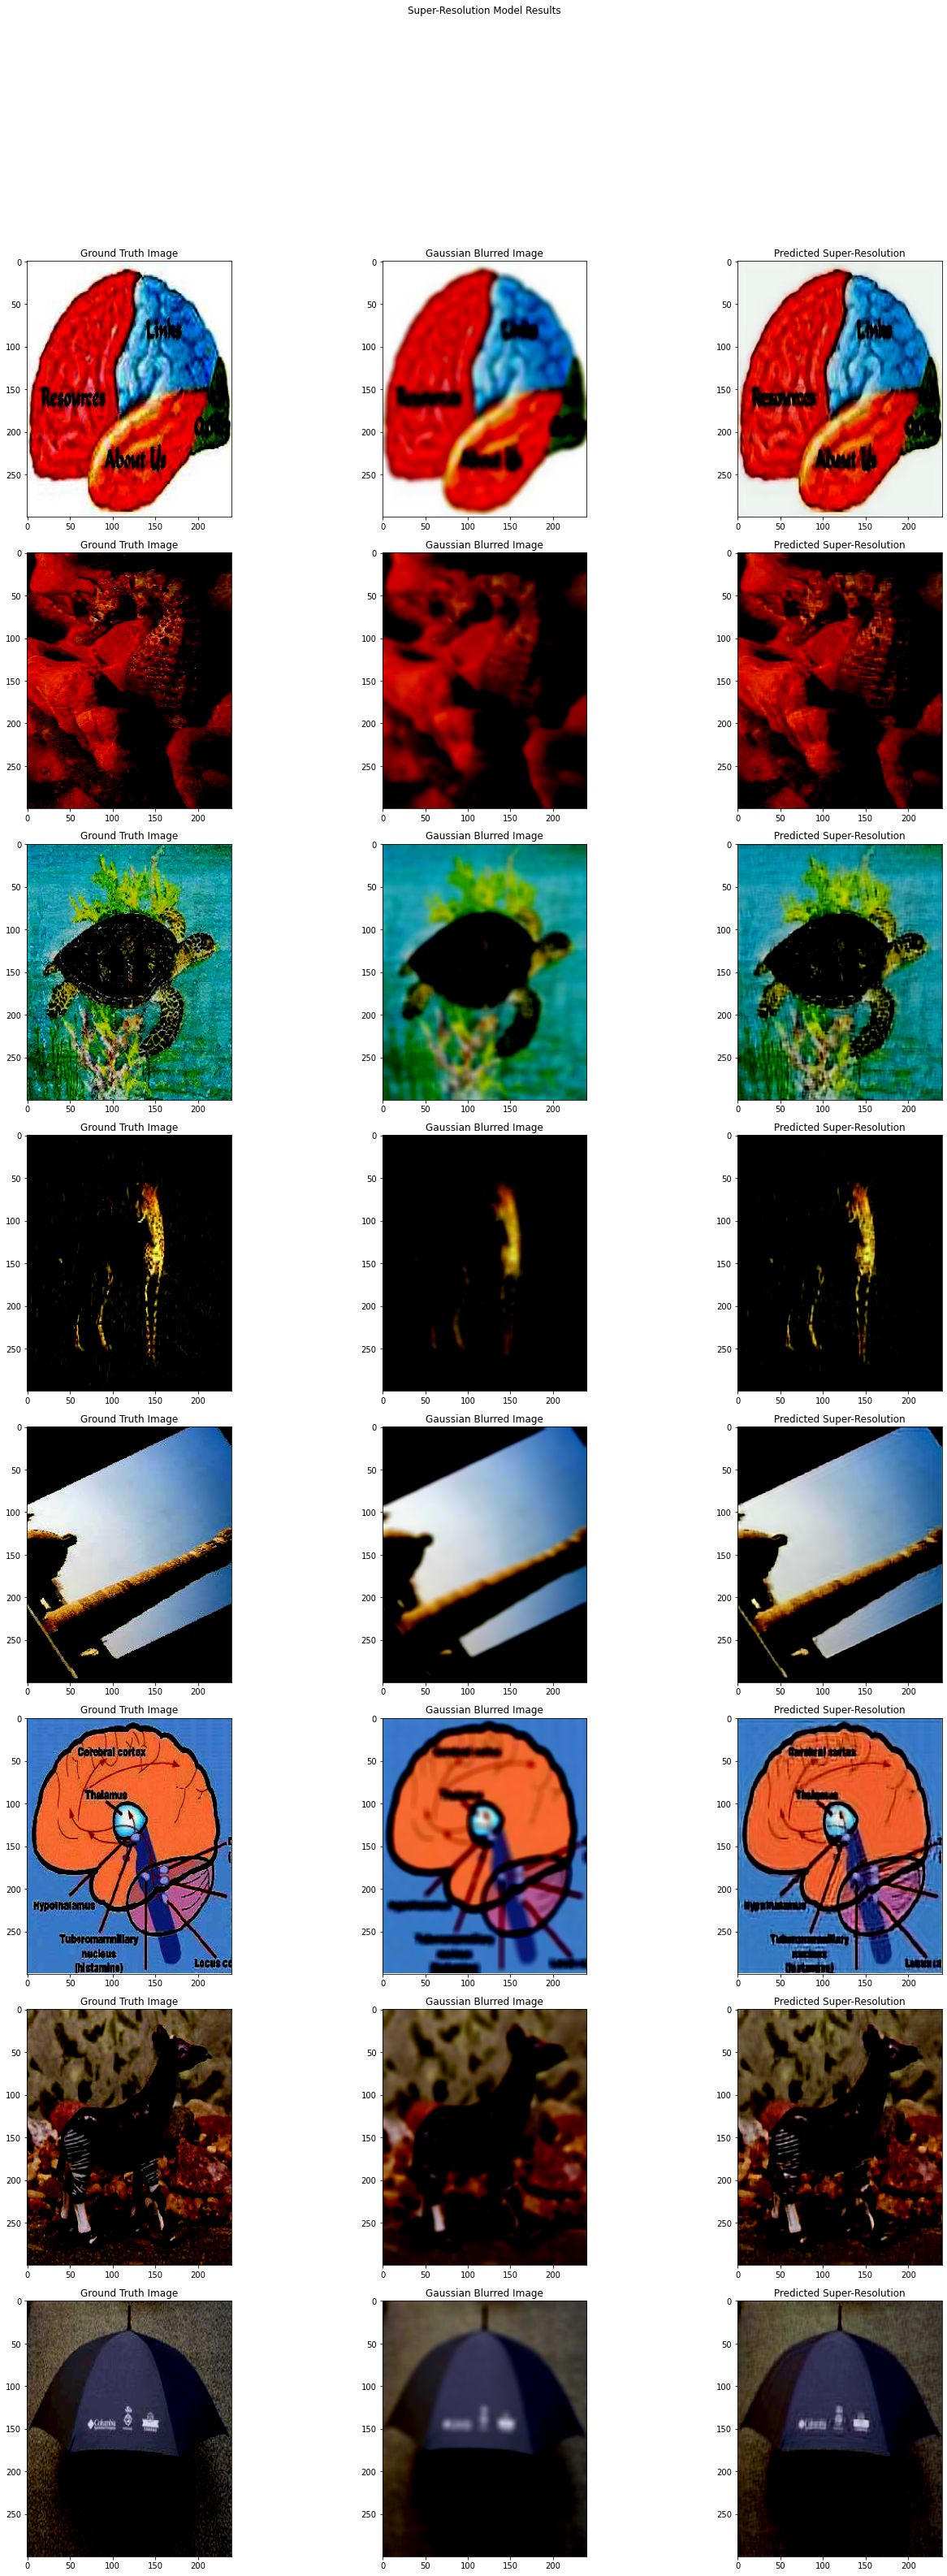

In [ ]:
##Import necessary plotting package
import matplotlib.pyplot as plt

##Use function to plot random image from previous notebooks
##Define a function that will display random samples for each class for us
def display_resolution_rand_samples(num_samps,x_val,y_val,title):
  
  ##Generate random samples
  randomSamples = np.random.random_integers(len(x_val),size=num_samps)

  ##Create figure to output images onto
  fig, ax = plt.subplots(num_samps,3,figsize=(20,40))

  ##Loop through labels to display random samples for each label onto subplot
  ct = 0
  for i in randomSamples:

      ##Display the images
      ax[ct,0].imshow(y_val[i],cmap='gray')
      ax[ct,1].imshow(x_val[i],cmap='gray')
      ax[ct,2].imshow(autoencoder.predict(x_val)[i],cmap='gray')

      ax[ct,0].title.set_text('Ground Truth Image')
      ax[ct,1].title.set_text('Gaussian Blurred Image')
      ax[ct,2].title.set_text('Predicted Super-Resolution')
      ##Declare the titles
      ct+=1

  ##Format overall plot structure
  fig.suptitle(title,y=1.1)
  fig.tight_layout()

##Call the function to plot random observations from each super-class (coarse labels)
np.random.seed(11) ##Set random seed so visualization results can be replicated
display_resolution_rand_samples(8,x_val,y_val,'Super-Resolution Model Results')

We can see in the results above that even though training was stopped relatively early, that a fair amount of the blurred out resolution is being re-gained by our model. Very specifically I am impressed with the following things:
* In row 1, when Guassian blurring is performed on the diagram of the brain, none of the words are legible anymore, however the Super-Resolution model is able to predict a picture where you can clearly see the words "Resources", "Limbs", and "About Us". To me this is really amazing and cool to see, I didn't think super-resolution had this type of power. 
* In row 4, Gaussian blurring omits many details of the Cheetah's face, but the super-resolution model is able to restore many of these details like the mouth and ear
* In row 7, Super-resolution is able to restore the stripes on the animals leg that we partially removed during blurring

I could now see super-resolution having a ton of useful applications. I'd specifically be interested to see if intelligence agencies use this type of technology to better piece together images for important scenes. 

You can notice that the above predictions were performed on the validation data. This is because for this specific notebook, as cited above, I am going to evaluate test results on the CIFAR-100 dataset to see if the model translates. That analysis is below. 

In [ ]:
##Free up Ram
del x_train
del y_train
del x_val
del y_val

### Results on CIFAR-100 Super-Resolution

Now to visually see how well this Super-Resolution model works on brand new data, we will pull in the CIFAR-100 dataset and make some super-resolution predictions onto it. 

In [ ]:
from tensorflow import keras

##Load the CIFAR-100 dataset
##Assistance from keras documentation to assert proper shapes: https://keras.io/api/datasets/cifar100/
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data() 
assert x_test.shape == (10000, 32, 32, 3)

##Free up RAM
del x_train
del y_train
del y_test

169017344/169001437 [==============================] - 3s 0us/step


Resize the CIFAR-100 images to be the dimensions that our Caltech-101 images were above. 

In [ ]:
##Cifar storage location
cifar = []

##Change resolution of images
for i in range(len(x_test)):
  resized = cv2.resize(x_test[i], (240,300), interpolation = cv2.INTER_AREA)
  cifar.append(resized)

##Free up ram
del x_test

In [ ]:
##Put data into a numpy array
cifar = np.array(cifar)

Make predictions on the CIFAR-100 images and display the results:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 300 + 1) instead
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imsho

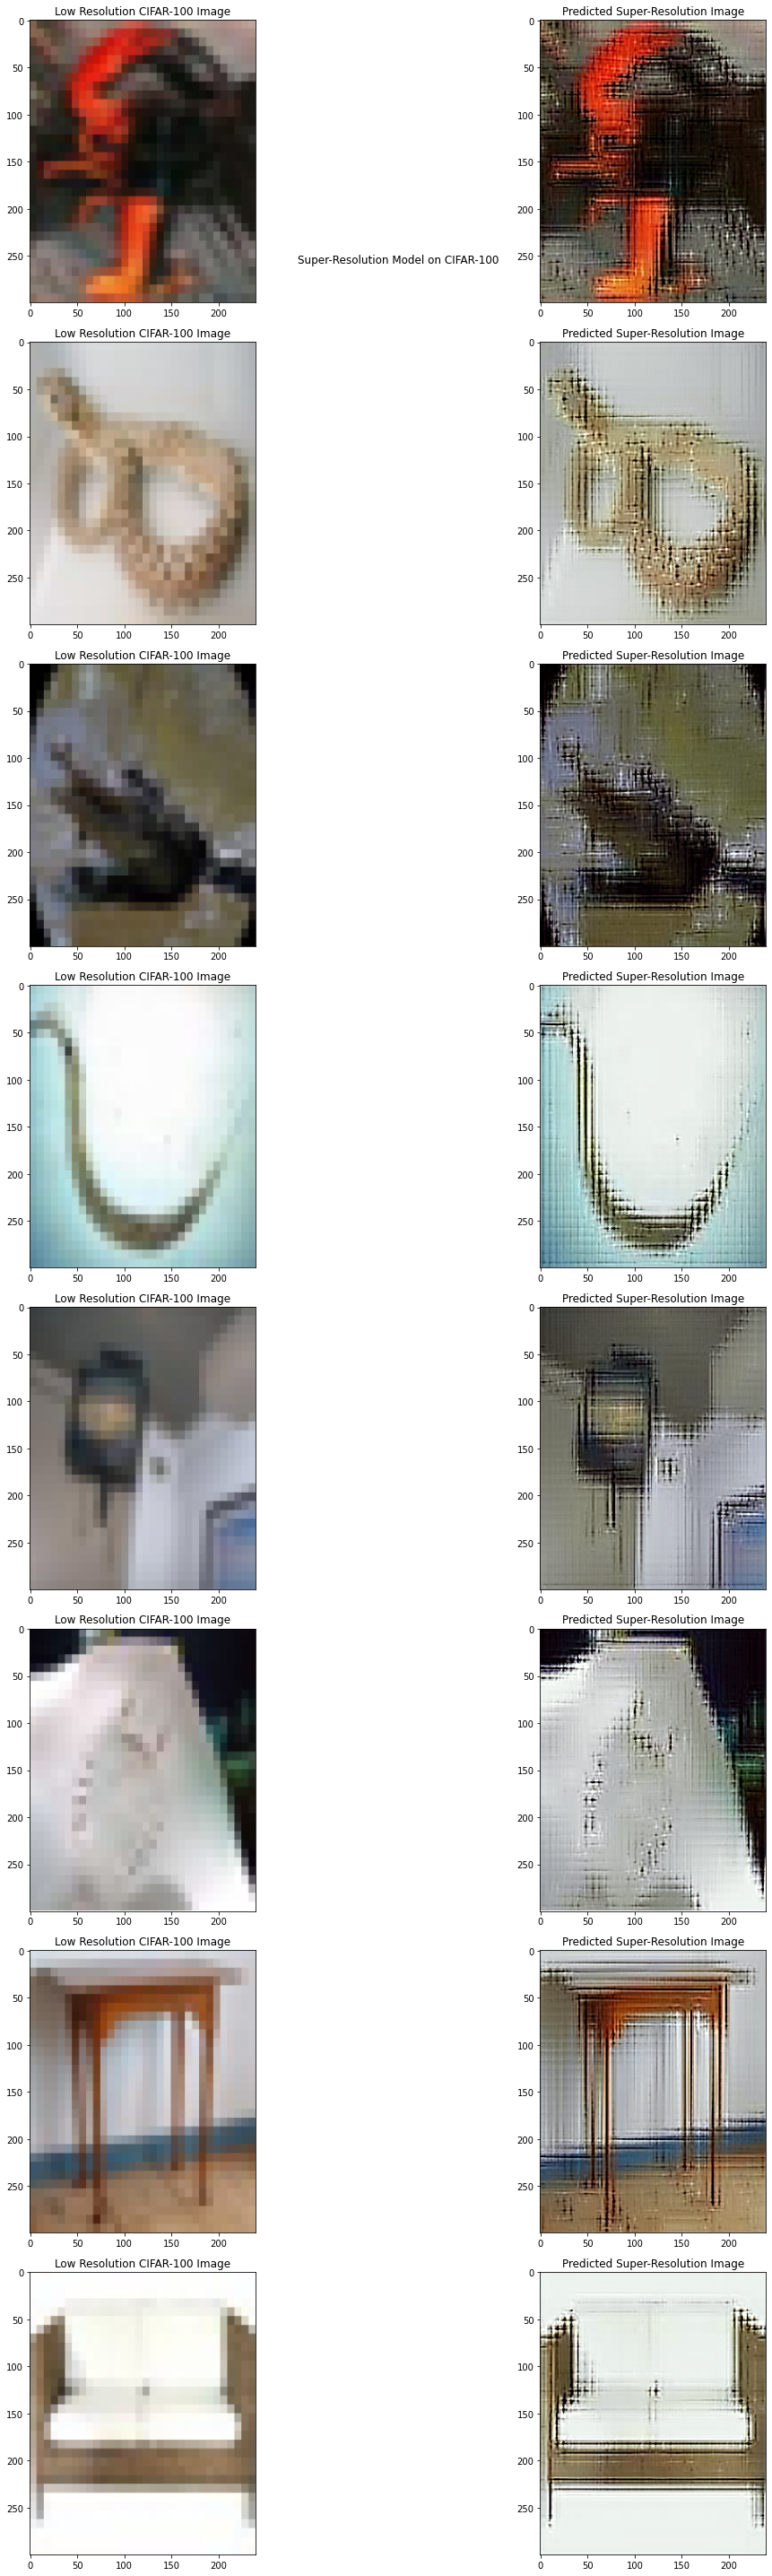

In [ ]:
##Import necessary plotting package
import matplotlib.pyplot as plt

##Use function to plot random image from previous notebooks
##Define a function that will display random samples for each class for us
def display_cifar_rand_samples(num_samps,cifar,title):
  
  ##Generate random samples
  randomSamples = np.random.random_integers(len(x_val),size=num_samps)

  ##Create figure to output images onto
  fig, ax = plt.subplots(num_samps,2,figsize=(20,40))

  ##Loop through labels to display random samples for each label onto subplot
  ct = 0
  for i in randomSamples:

      ##Display the images
      ax[ct,0].imshow(cifar[i],cmap='gray')
      ax[ct,1].imshow(autoencoder.predict(cifar[i].reshape(1,300,240,3)/255)[0],cmap='gray')

      ax[ct,0].title.set_text('Low Resolution CIFAR-100 Image')
      ax[ct,1].title.set_text('Predicted Super-Resolution Image')
      ##Declare the titles
      ct+=1

  ##Format overall plot structure
  fig.suptitle(title,y=.9)
  fig.tight_layout()

##Call the function to plot random observations from each super-class (coarse labels)
np.random.seed(11) ##Set random seed so visualization results can be replicated
display_cifar_rand_samples(8,cifar,'Super-Resolution Model on CIFAR-100')

We can see that the results above are not super encouraging in terms of the providing higher resolution for the CIFAR-100 dataset. My main hypothesis as to why this failure occured is because the resolution of the CIFAR-100 images seems still much lower than the Gaussian blurred Caltech-101 images the model was trained on. Here are a few observations that outline some positives and some negatives:
* In the last two rows, the super-resolution model does do a decent job at making the furniture items clearer like the table legs and the chair seat
* In row 6, the super-resolution model does seem to increase the resolution of the sting-rays "face" allowing us to see some more pronounced details of its mouth structure
* In row 1, the super-resolution model seems to add some horizontal and vertical black lines to the image but this doesn't seem to do much in the sense of making the image clearer

## Final Thoughts

Overall this Super-resolution experiment was probably my favorite task of the semester. I think that Caltech-101 is a good dataset to use for training the super-resolution task because of the diversity of data in it. However, I think the models ability to translate onto the CIFAR-100 dataset came down to two things. The first is that the blurring effect on the Caltech-100 data probably needed to lower the resolution even more so it could generalize better to CIFAR-100. Secondly, the limited RAM even with Google Collab pro prevented me from using more training data which would have made the model more robust to increasing resolution in different datasets. I am pretty suprised that even after paying for Collab Pro, that the RAM is limited so much. 